# DataFed Tutorial

Based on work by Joshua Brown, Edited by Joshua Agar.

The tutorial has been tested on python versions 3.8.10 and 3.7.14. Later versions of Python are also expected to work correctly. To minimize the barrier to getting started the tutorial will be run on Google Collab though it should be possible to execute directly in a terminal depending on the exact set up of your machine you may run into problems.

To use Google Collab navigate to [Colab](https://colab.research.google.com/) you should be able to use a Google email account to sign into Google Collab. You will also need to have a Globus ID. If you have signed into Globus with your institutional credentials you may not have a Globus identity linked to your Globus account.
[Globus](https://www.globus.org/) Login to Globus, once logged into Globus there is an accounts button on the left navigation bar click on it. It should list 1 or more email addresses. If you do not see a globusid.org email address then you will need to create one. To do this you will need to first log out. If you revisit the login screen shown below, there is some small blue text that appears on the bottom under the "Sign in with Google" and "Sign in with ORCID iD" buttons, you will want to click on it and create a new account.

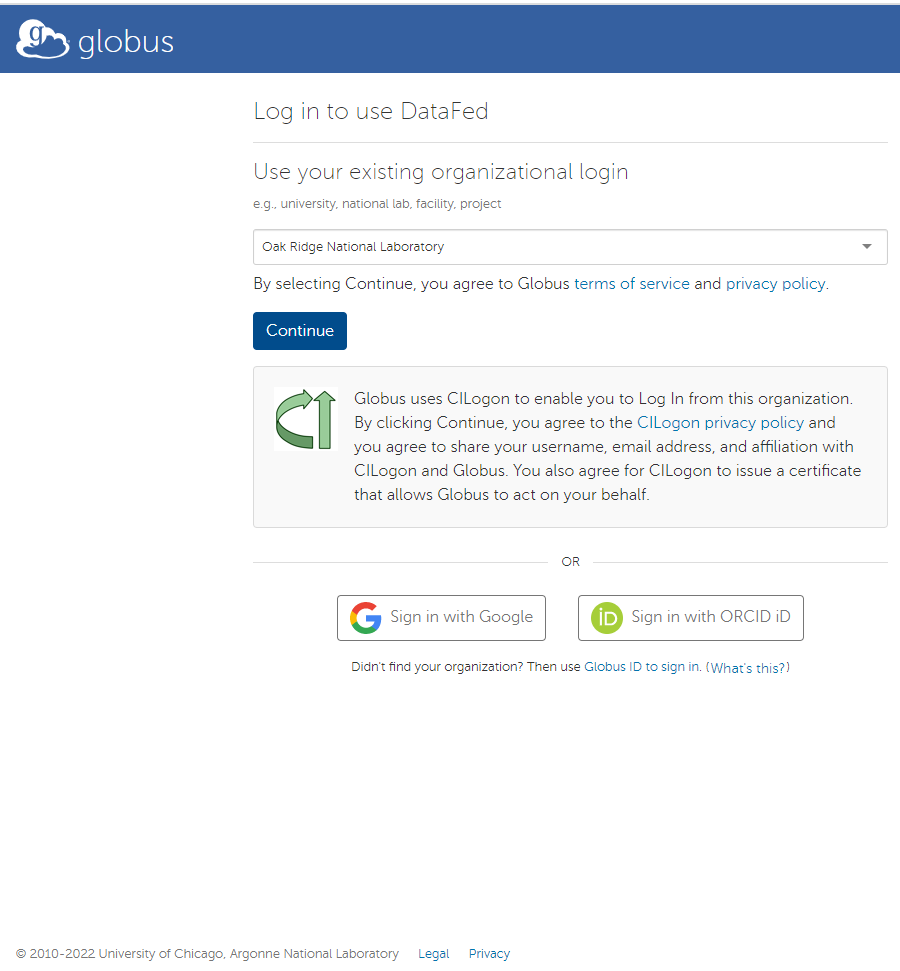


# Tutorial Steps

All commands used in this tutorial are documented on the DataFed documentation pages: [DataFed Guide](https://ornl.github.io/DataFed/user/python/high_level_guide.html)

There are a total of 9 steps included in this tutorial.

1. Install DataFed Python Module
2. Verify User Authentication
3. Ensure Globus Endpoint is Set
4. List Content of User Space
5. Creating Folders/Collections
6. Adding Raw Data to a Data Record
7. Adding Raw Data to a Record without Uploading to DataFed Repo
8. Downloading Raw Data to a Different Globus Endpoint
9. Grabbing a Metadata Record from DataFed

# Desired Outcomes

At the end of this tutorial you should have some idea of how to:
1. Create a record on DataFed with both custom metadata
2. Attach raw data to a DataFed record without moving the raw data
3. Upload raw data to a DataFed repository
4. Transfer raw data from a DataFed Repository or Globus Endpoint to another Globus endpoint.
5. Get the custom metadata for a record from DataFed

## 1. Install DataFed Python Module


In [ ]:
! pip install datafed pwinput

In [ ]:
import os
import json
import getpass
import subprocess
from platform import platform
import sys

from datafed.CommandLib import API
from datafed import version as df_ver

print(df_ver)
df_api = API()

## 2. Verify User Authentication

Make sure you have your DataFed username and password available. Your username is viewable in the DataFed web UI.

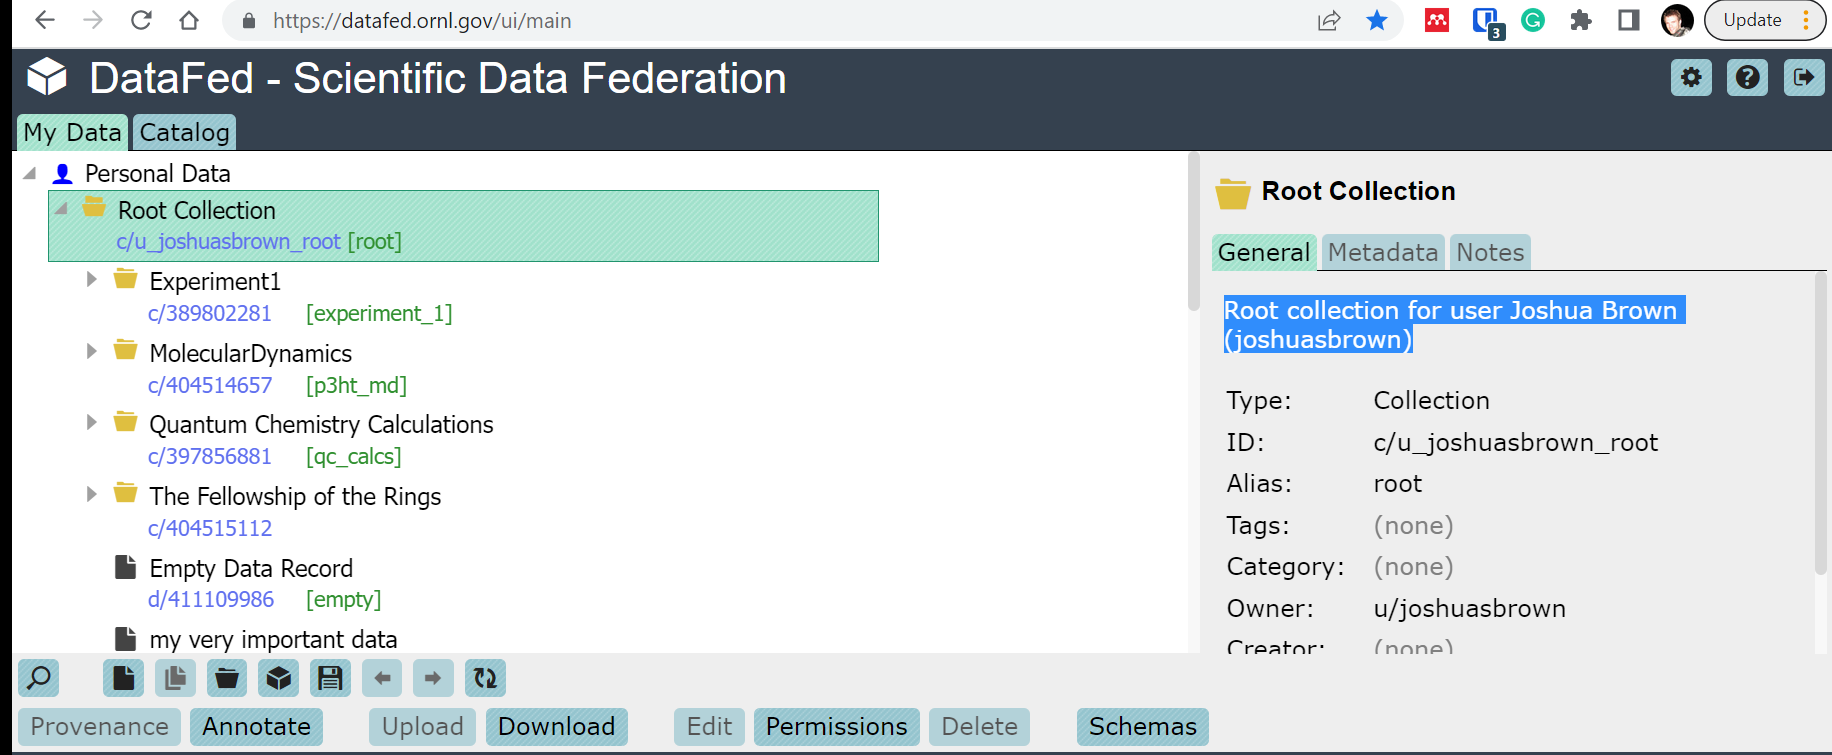

If you have forgotten your password you can change it in the Web portal. By clickingon the settings icon in the top right corner.

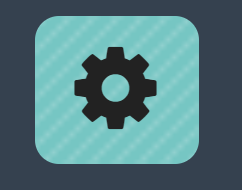

This will open a new window where you can change your password.

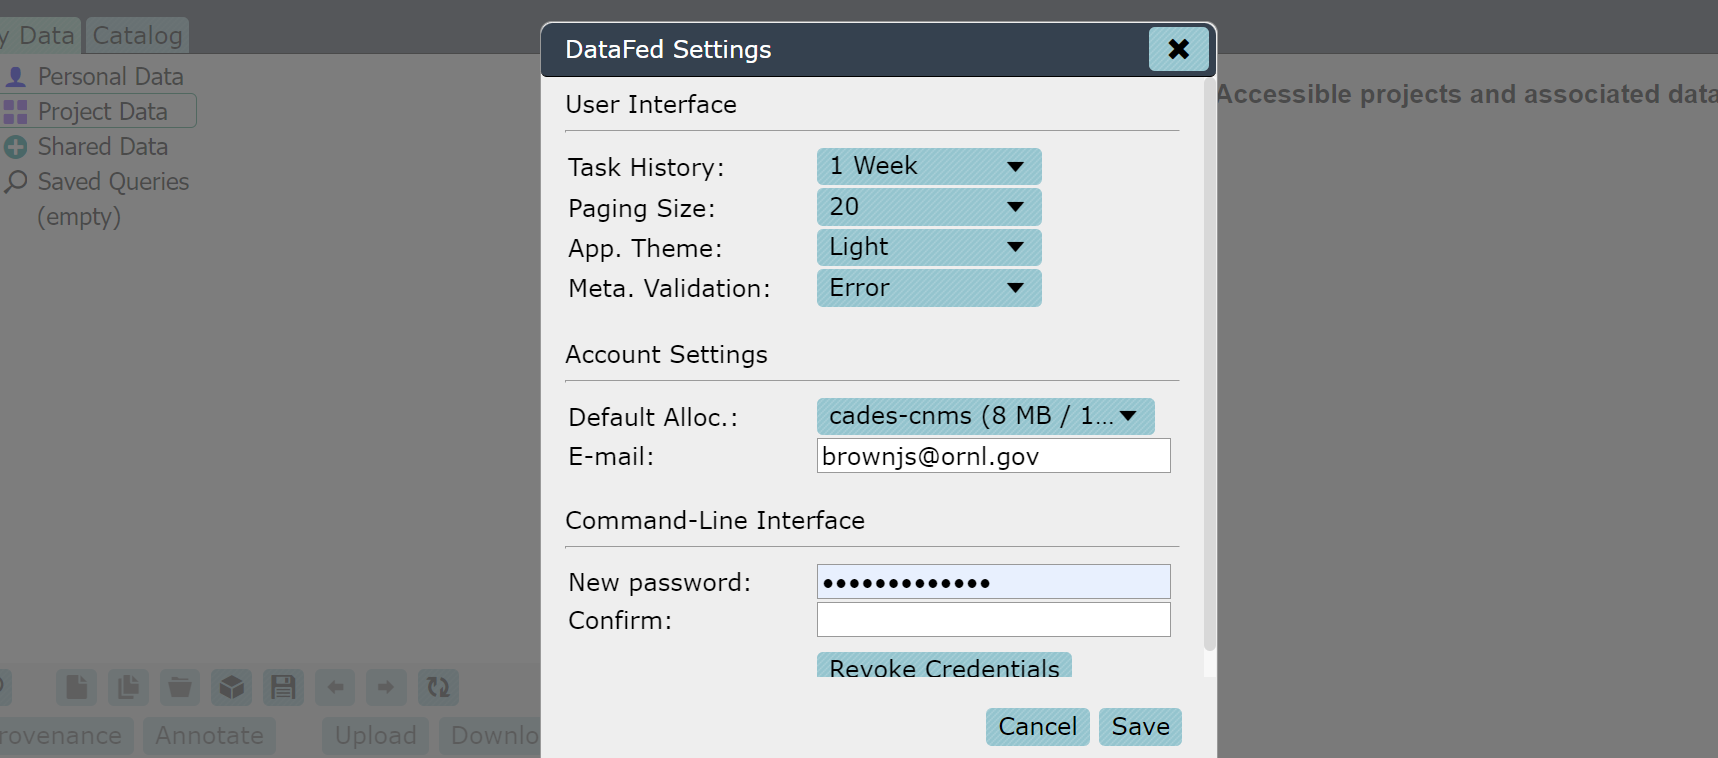


In [ ]:
username = "jca318" # Replace this with your DataFed username
password = getpass.getpass()

In [ ]:
if not df_api.getAuthUser():
 df_api.loginByPassword(username, password)

print('Success! You have been authenticated into ')
print('DataFed as: ' + df_api.getAuthUser())

## 3. Ensure Globus Endpoint is Set

Though not strictly necessary for the majority of the tutorial, for the best experience I would recommend you install Globus Connect Personal on your personal machine if you have not already done so.

[Globus Personal](https://www.globus.org/globus-connect-personal)

If you installed Globus Connect Personal you can get the UUID for the endpoint by logging into Globus and searching for the endpoint with the name that was used when it was set up. You can get the name by clicking on the Globus Icon that should exist in the navigation bar of your
operating system. Shown below is for a windows 11 machine. I have an endpoint named "FireFlyLaptop".

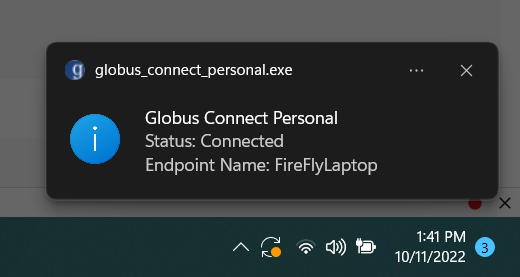

Go to [Globus File Manager](https://app.globus.org/file-manager) , and search for the endpoint. Then click on the kebab button (3 vertical dots) that appear next to the search bar.

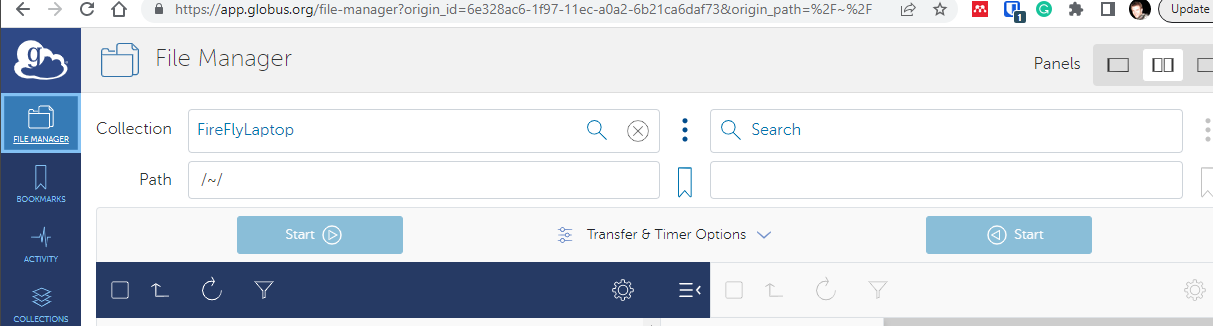

On the next page you will find the UUID of the endpoint you will want this uuid.

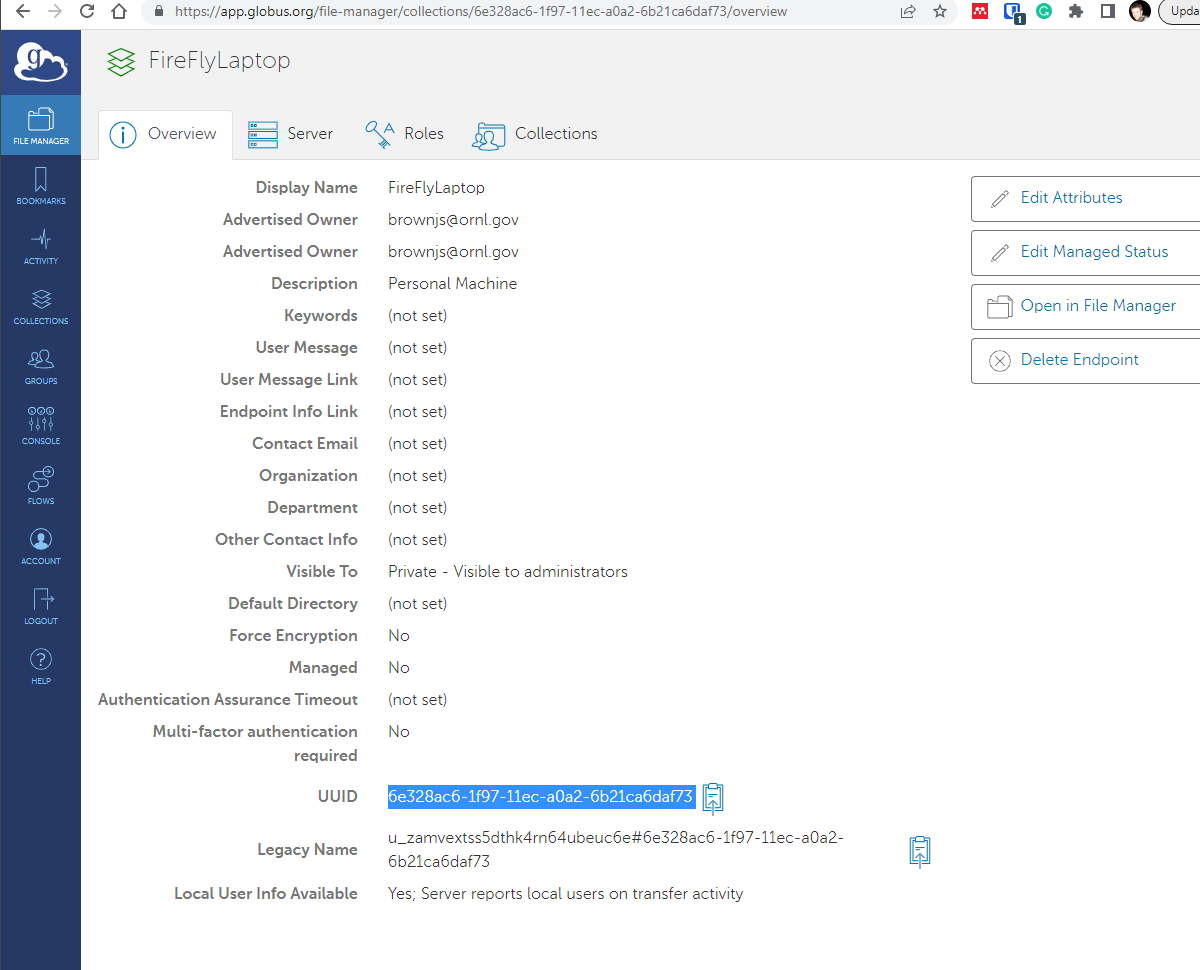


In [ ]:
if not df_api.endpointDefaultGet():
  msg = '\nPlease enter either the Endpoint UUID '
  msg = msg + 'or Legacy Name for the Endpoint.\n'
  endpoint = input(msg)
  df_api.endpointDefaultSet(endpoint)

print('Your default Globus Endpoint in DataFed is:\n')
print(df_api.endpointDefaultGet())

If this is not the endpoint you want to use, you can list Globus endpoints that have been recently accessed.

In [ ]:
df_api.endpointListRecent()

## 4. List Content of User Space

DataFed has both a project preceded by a 'p/' and a user context preceded by a 'u/', you can specify which context you are working in, it is important to know which context you are working in, so that you don't change, upload, attempt to download files from and or in the wrong context.

In [ ]:
df_api.getContext()

In DataFed, you can organize records into collections which are similar to folders or directories. We can list the contents that are in a collection by specifying the parent folder. A collection named 'root' always exists at the top of the collection hierarchy.

In [ ]:
# Here you will to put your username
#df_api.collectionItemsList('root', context='p/training_project')
# You can list contents of a sub collection by simply replacing 'root'
# with the collection id. Because I am working in my default user context
# I do not have to explicitly list the context. An equivalent command would be:
#
df_api.collectionItemsList('root')

You can also list the contents of collection by either specifying the id or using the alias.

* The id is a globally unique identifier
* The alias is a contextually unique, user-friendly identifer i.e unique to your user context, or unique to a project context

In the cell below, collection 'c/389802281' is equivalent to 'experiment_1', the only difference being the collection id is used in one case and the alias in the other.

STOP: Go ahead and create a collection in your user context using the web UI, replace the collection id and alias used below with the new collection and rerun the commands.

In [ ]:
print("Contents listed using collection id\n")
# You will need to replace the collection id with one that appears in your user
# account
print(df_api.collectionItemsList('c/525610518'))
print("\nContents listed using collection alias\n")
print(df_api.collectionItemsList("root", context='u/' + username))

There are two types of contexts, your personal user context and a project context. To change the context I just have to specify the project identifier.

In [ ]:
df_api.setContext('p/2025-isaf-pfm')
df_api.getContext()

Because we have switched the context in which we are working we no longer need to explicitly list the project when listing the items in the project.


In [ ]:
df_api.collectionItemsList('root')

## 5. Creating Folders/Collections

In this section, we will proceed by creating a collection with the name of our username. It will be created in the 'p/training_project' context, if you correctly switched the context in Step 4.

In [ ]:
# If you get an error here it is likely that you have already created a
# collection with the same alias
col_result_username = df_api.collectionCreate(
    title=username,
    alias=username,
    parent_id='c/p_2025-isaf-pfm_root')

print(col_result_username)

col_id_username = col_result_username[0].coll[0].id

print('\nJust the collection id.')
print(col_id_username)

For now, we will need to convert the metadata to a JSON string using the dumps() function in the json package.

In [ ]:
parameters = {
 'testing_temperature': 90000,
 'voltage': [1, 2, -4, 7.123],
 'creator': 'Lex Luther',
 'occupation': 'super villian',
 'equipment_serial_numbers': {
  'SEM': 14, # Can use nested dictionaries
  'AFM': -19
  }
 }


In [ ]:
# Because we are working in a shared project we will append
# our usernames to the alias to avoid name collisions
dc_resp = df_api.dataCreate('Kryptonite', # title - required
 alias="kryptonite_2" + username,
 metadata=json.dumps(parameters), # optional
 tags=["material"],
 parent_id=col_id_username, # The parent collection
 )

dc_resp

## 6. Adding Raw Data to a Data Record

Notice, when we look over at the web ui, the data record appears black or grayed out, this is to indicate that there is no raw data associated with the record. To add raw data to the record we will need to have data somewhere on a Globus Endpoint that can be referenced.

There are several different ways which you can add a data record

### Raw Data From an Public Endpoint

#### 1. Define the Dictionary of Metadata

In [ ]:
parameters = {
 'testing_temperature': 900000,
 'voltage': [1, 2, -4, 7.123],
 'creator': 'Lex Luther',
 'occupation': 'super villian',
 'equipment_serial_numbers': {
  'SEM': 14, # Can use nested dictionaries
  'AFM': -19
  }
 }

#### 2. Create the Data Record

In [ ]:
# Because we are working in a shared project we will append
# our usernames to the alias to avoid name collisions
dc_resp = df_api.dataCreate('Public-data-record', # title - required
 alias="public-data-" + username,
 metadata=json.dumps(parameters), # optional
 tags=["material"],
 parent_id=col_id_username, # The parent collection
 )

dc_resp

#### Transfer the Data from Public Endpoint

In [ ]:
endpoint = "82f1b5c6-6e9b-11e5-ba47-22000b92c6ec"
path_to_file = "/foundry/double_perovskite_bandgap_v1.1/Dataset_double_perovskites_gap_v1.csv"

response = df_api.dataPut("public-data-" + username, endpoint + path_to_file)
print(response)

### Adding Data from a Personal Endpoint

In [ ]:
import platform
import os
import psutil

def get_system_parameters():
    return {
        'os': platform.system(),
        'os_version': platform.version(),
        'platform': platform.platform(),
        'architecture': platform.machine(),
        'processor': platform.processor(),
        'cpu_count_logical': psutil.cpu_count(logical=True),
        'cpu_count_physical': psutil.cpu_count(logical=False),
        'memory_total_gb': round(psutil.virtual_memory().total / (1024 ** 3), 2),
        'disk_total_gb': round(psutil.disk_usage('/').total / (1024 ** 3), 2),
        'python_version': platform.python_version(),
        'env_vars': dict(os.environ),  # You can filter this if too large
    }

sys_info = get_system_parameters()

parameters = {
 'testing_temperature': 1,
  'system_parameters': get_system_parameters()
 }

In [ ]:
# Because we are working in a shared project we will append
# our usernames to the alias to avoid name collisions
dc_resp = df_api.dataCreate('Public-data-record', # title - required
 alias="personal-data-" + username,
 metadata=json.dumps(parameters), # optional
 tags=["material"],
 parent_id=col_id_username, # The parent collection
 )

dc_resp

In [ ]:
personal_endpoint = "2c4afb2a-9aa3-11ec-bf8a-ab28bf5d96bb"
path_to_file_on_personal_endpoint = "/Users/joshuaagar/Globus-Personal-Docker/notes.md"

response = df_api.dataPut("personal-data-" + username, personal_endpoint + path_to_file_on_personal_endpoint)

response = df_api.dataPut("personal-data-" + username, personal_endpoint + path_to_file_on_personal_endpoint)
print(response)

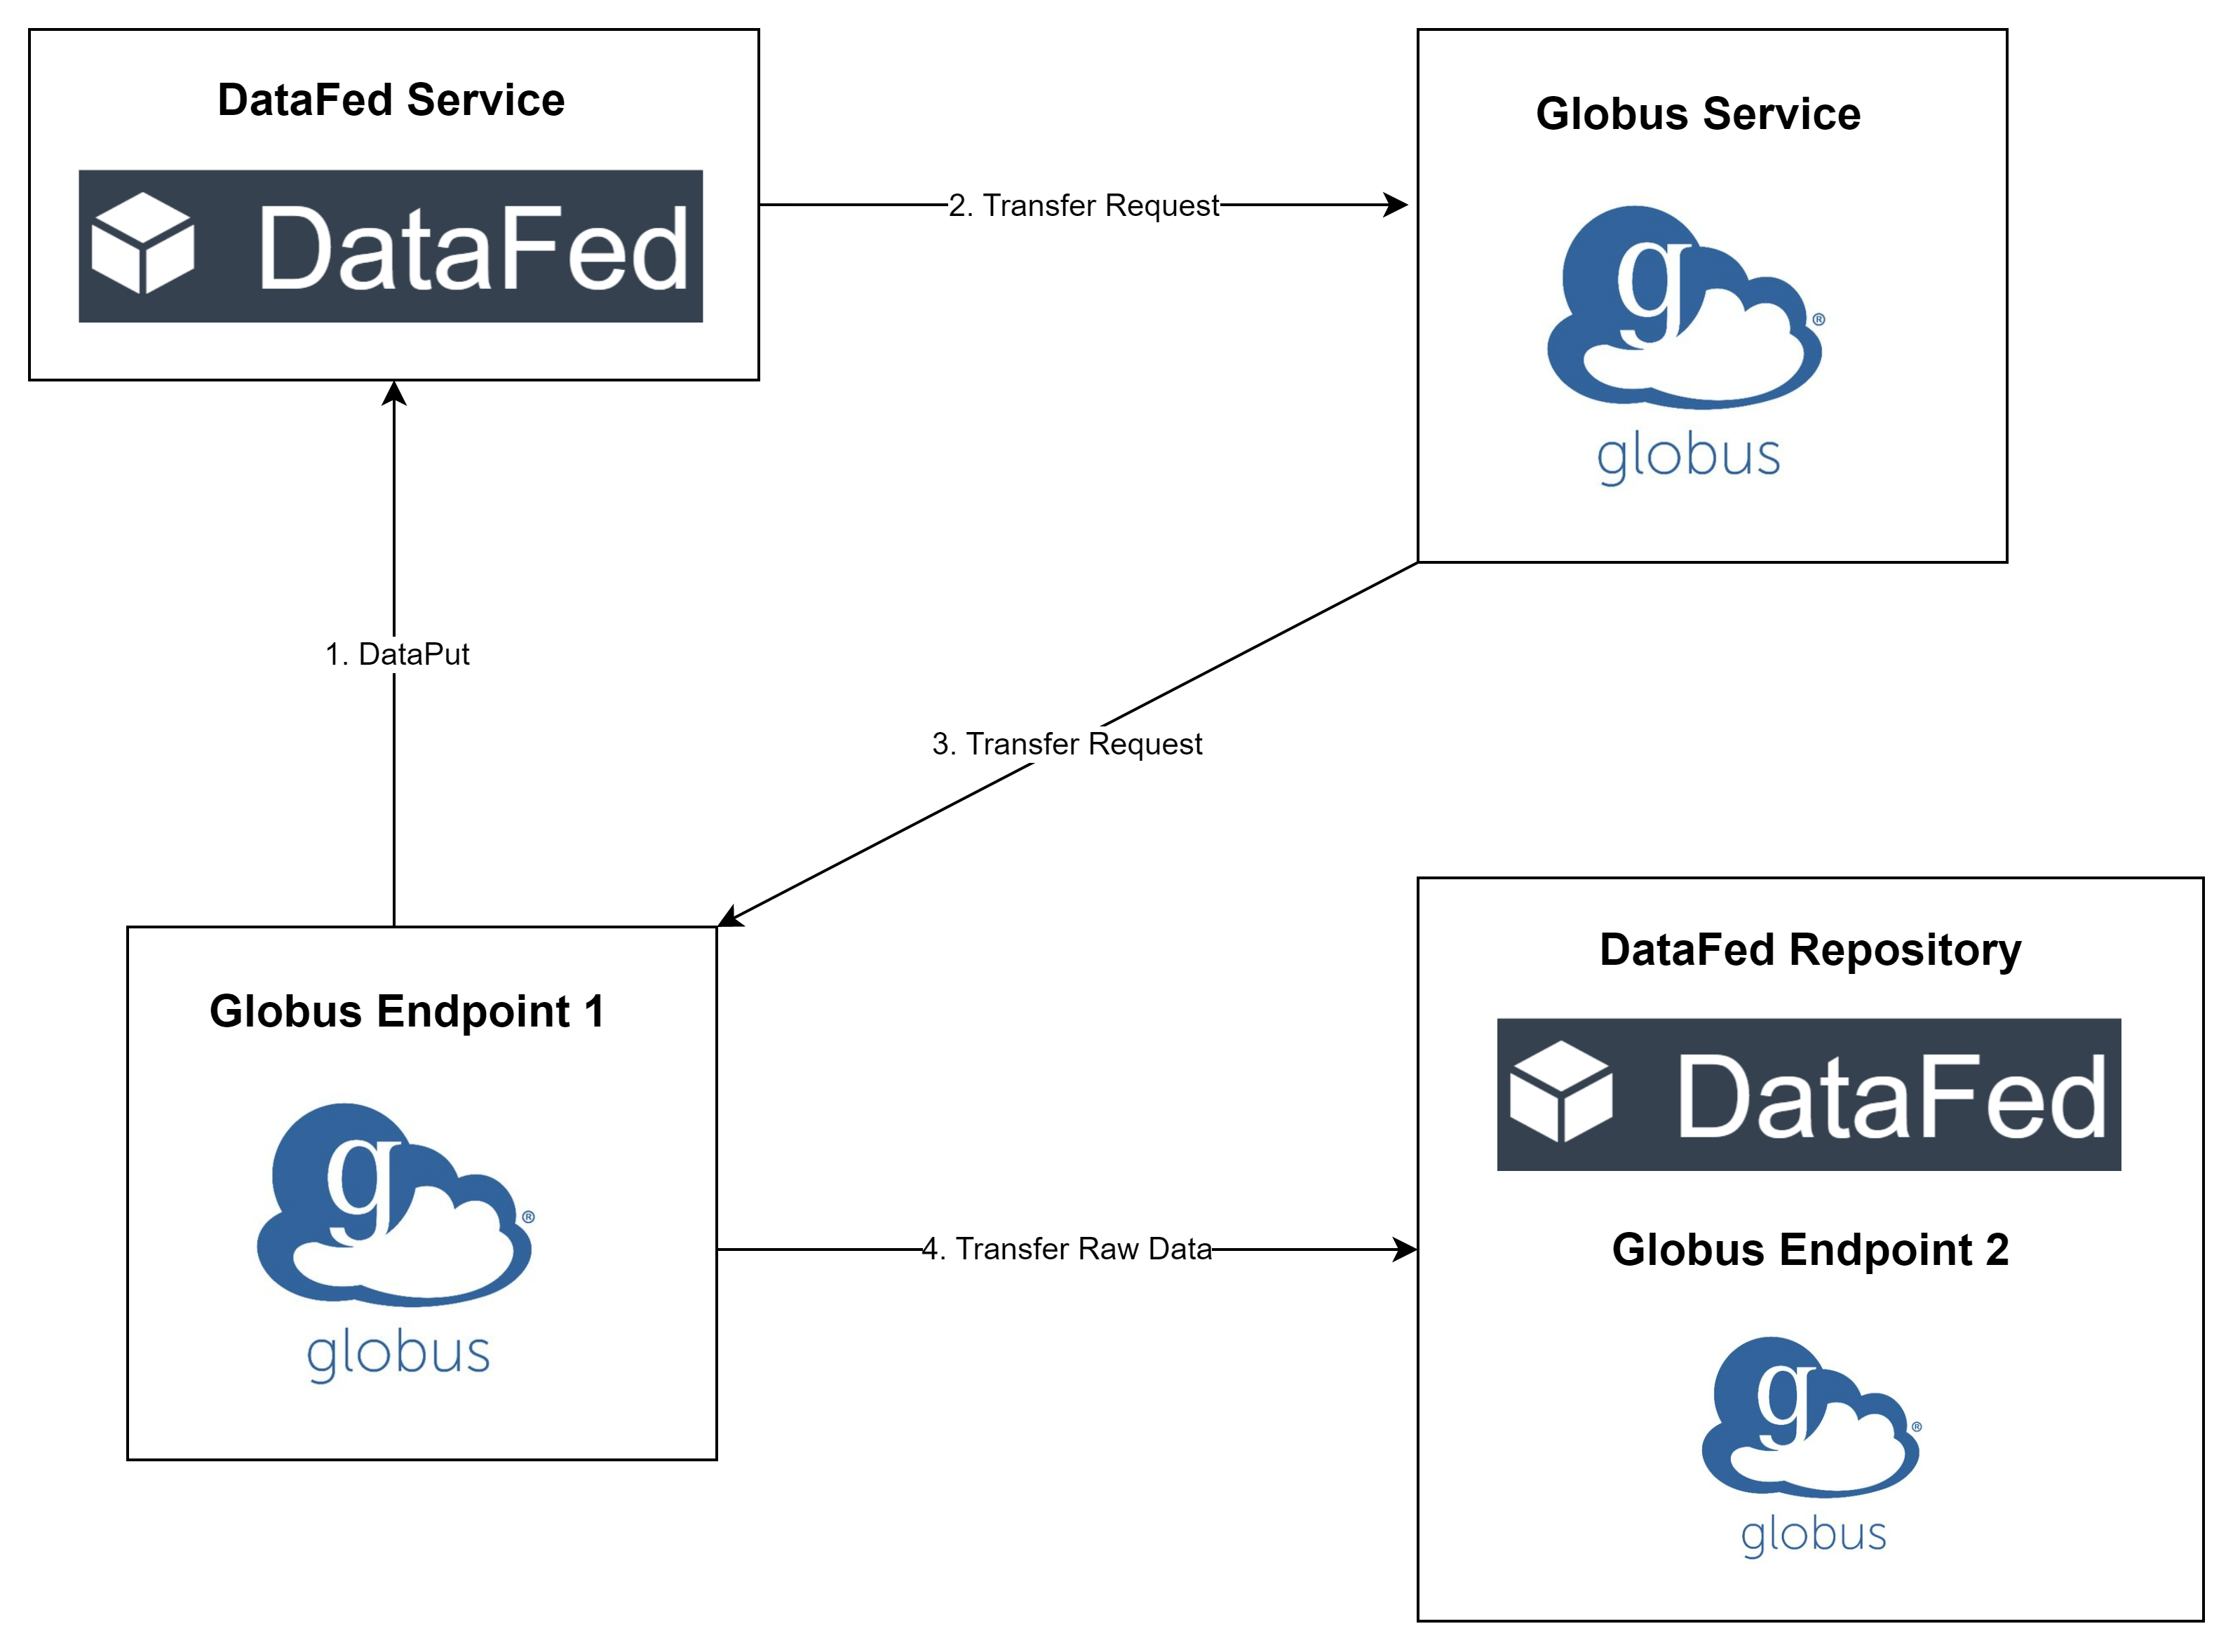

## 7. Adding Raw Data to a Record without Uploading to DataFed Repo

When we add data to a record with the dataPut command it adds the data to a DataFed managed endpoint, but what if you don't want to upload the data you just want to be able to organize the metadata while working with the data that is on your machine, this is also possible.

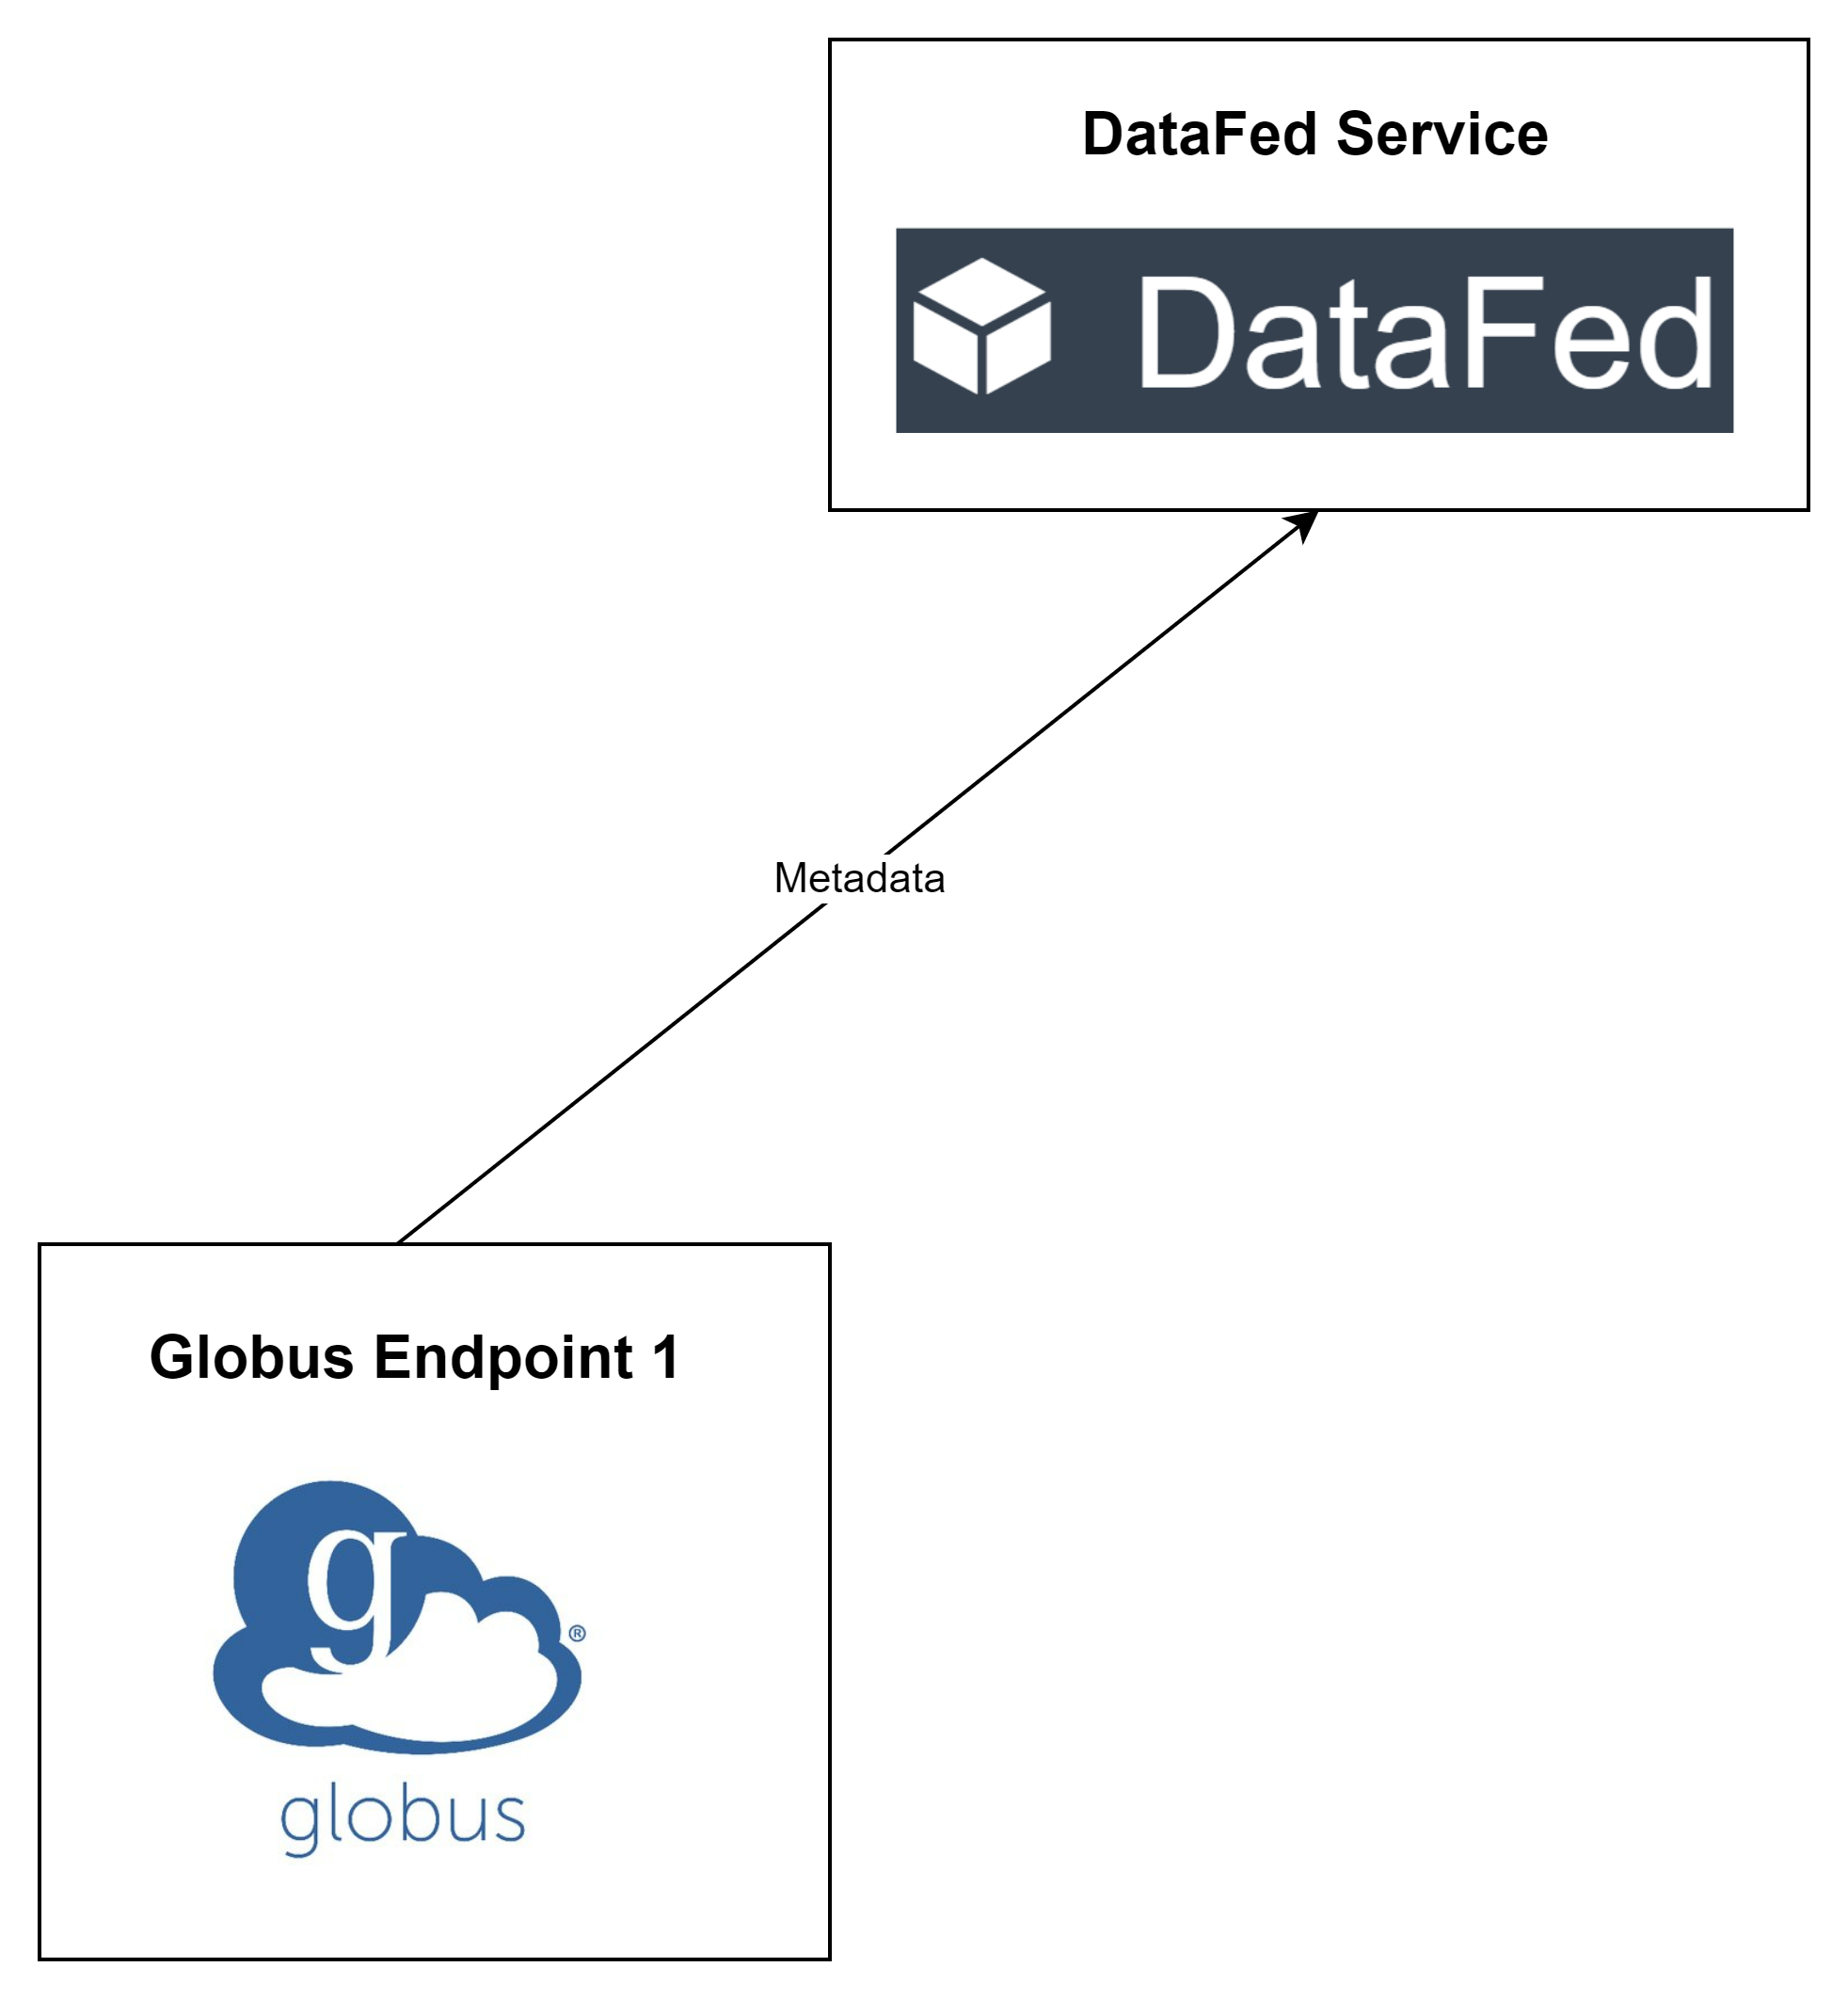

In [ ]:
parameters = {
  'testing_temperature': 100,
  'voltage': [10000, 500],
  'creator': 'Dwalin Oakenshield',
  'occupation': 'smith',
  'equipment_serial_numbers': {
  'Hammer': 23454, # Can use nested dictionaries
  'Forge': 9452
  }
 }


In [ ]:
dc_resp = df_api.dataCreate('Mythril', # title - required
 alias="linked-data" + username,
 metadata=json.dumps(parameters), # optional
 tags=["material"],
 parent_id=col_id_username, # The parent collection
 raw_data_file=endpoint + path_to_file,
 external=True
 )
dc_resp

## 8. Downloading Raw Data to a Different Globus Endpoint

How to move data between endpoints, say you want to transfer it from a DataFed managed repository to a Globus endpoint on your local machine. Again, here you will want to replace the below endpoint UUID with your own Globus UUID, that you should have received in Step 3.

Note for the Adamantium Record, we never actually moved any raw data when we created the record this is different from the Mythril Record which was uploaded to a DataFed Repository.

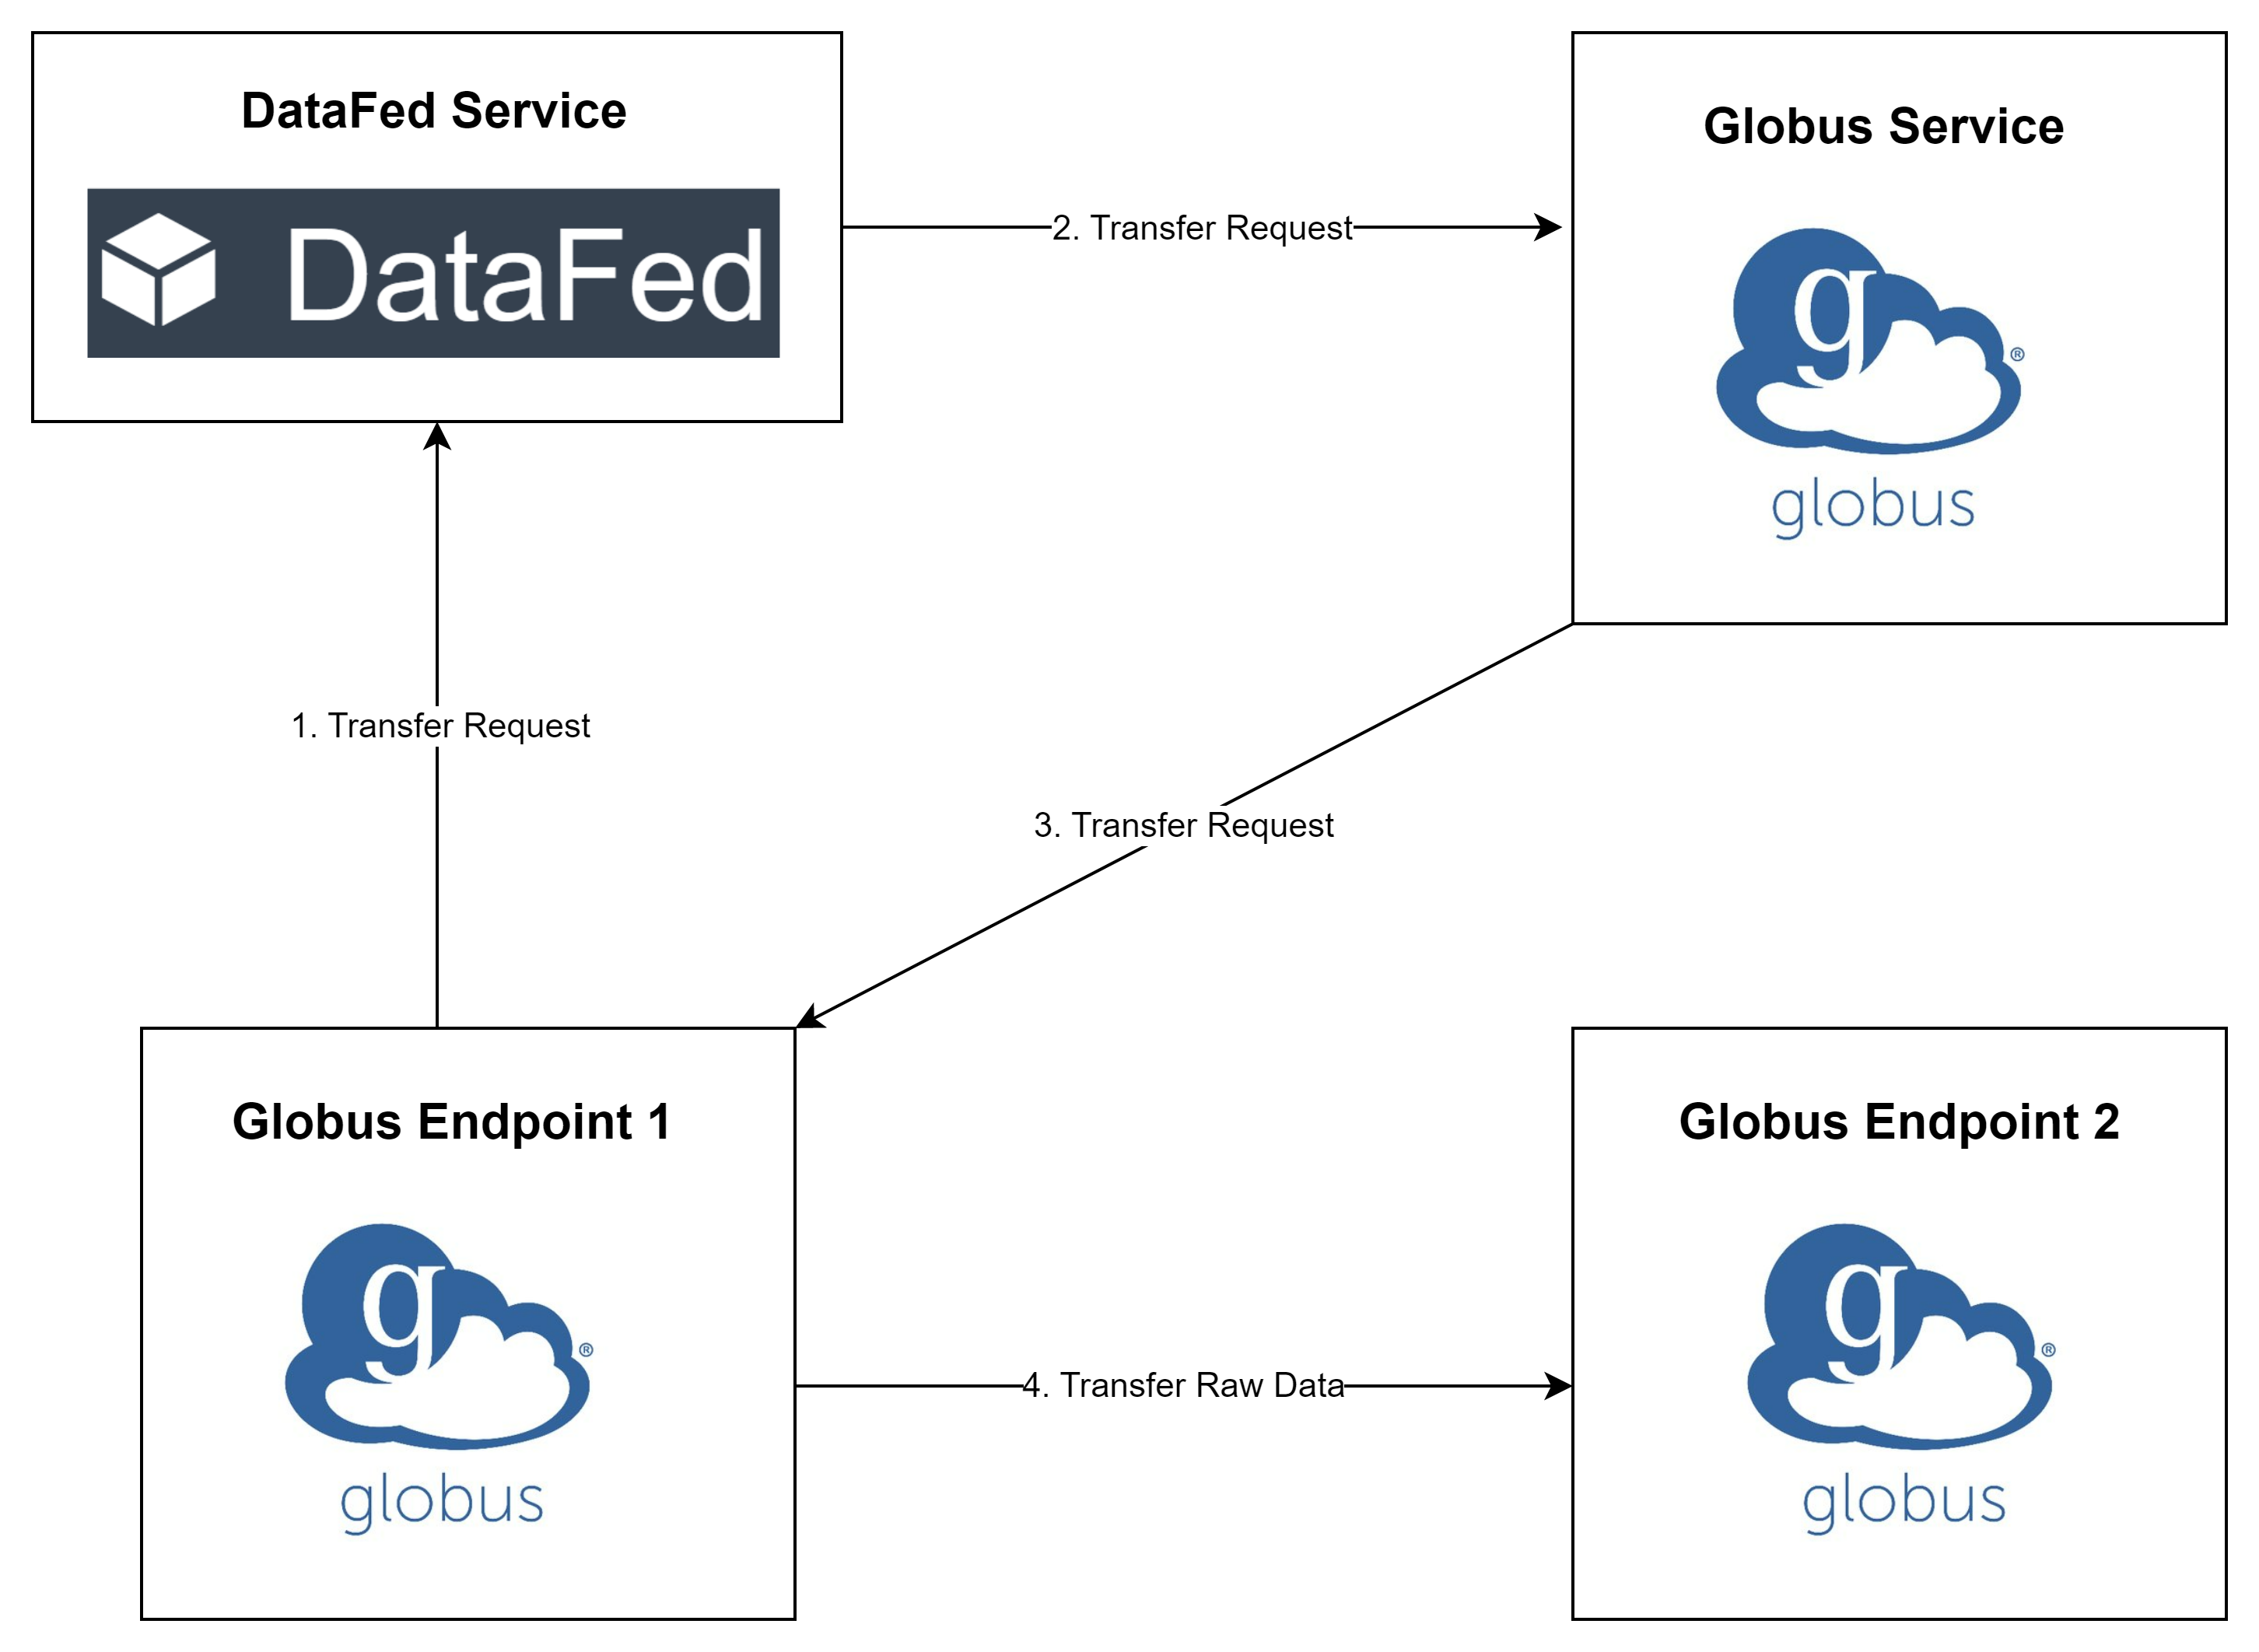


In [ ]:
# Replace this with your own Globus connect UUID
my_personal_laptop_globus_uuid = "2c4afb2a-9aa3-11ec-bf8a-ab28bf5d96bb"
# Path on my personal laptop where I want to download the data
path_on_personal_laptop = "/Users/joshuaagar/blah/"

df_api.endpointSet(my_personal_laptop_globus_uuid)
print('Set Endpoint')
print(df_api.endpointGet())

get_resp = df_api.dataGet("public-data-" + username,
 path=path_on_personal_laptop,
 wait=True, # Wait until Globus transfer completes
 orig_fname=True # Name the file the same name it had when it was uploaded
 )

print('\nTask')
print(get_resp)


## 9. Grabbing a Metadata from a Record in DataFed

In [ ]:
result = df_api.dataView("public-data-" + username)
print(result)

In [ ]:
custom_metadata = json.loads(result[0].data[0].metadata)
print(custom_metadata)